Demonstrate the use of `nucleobench` using PyPi.

Task: Count substrings.

In [1]:
# `nucleopt` is a minimal package that has nucleobench optimizers.
# For the full library, including tasks, install `nucleobench`.
!pip install nucleopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

Sanity test: use a neural network that counts substrings.

In [2]:
VOCAB = ['A', 'C', 'T', 'G']

import argparse
import torch
import torch.nn.functional as F
from typing import Optional

from nucleobench.common import string_utils

from nucleobench.optimizations import model_class as mc

class CountSubstringModel(torch.nn.Module):
    """Count number of substrings, using convs."""
    def __init__(self, substring: str, vocab: list[str] = VOCAB):
        super().__init__()
        self.substring = substring
        self.vocab = vocab

        self.substr_tensor = string_utils.dna2tensor(
            substring, vocab_list=self.vocab)
        self.substr_tensor = torch.unsqueeze(self.substr_tensor, dim=0)
        self.substr_tensor.requires_grad = False


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 3
        assert x.shape[1] == 4, x.shape
        out_tensor = F.conv1d(x, self.substr_tensor)
        out_tensor = torch.squeeze(out_tensor, 1)
        # We square it so it's nonlinear. That is, getting all 3 in one window should be
        # better than getting 2 in one window and 1 in another.
        out_tensor = torch.square(out_tensor)
        out_tensor = torch.sum(out_tensor, dim=1)

        # Flip the sign, so lower is better.
        out_tensor *= -1

        return out_tensor

    def inference_on_tensor(self, x: torch.Tensor) -> torch.Tensor:
        return self.forward(x)

    def __call__(self, seqs: list[str]):
        torch_seq = string_utils.dna2tensor_batch(seqs)
        result = self.inference_on_tensor(torch_seq)
        assert result.ndim == 1, result.shape
        return [float(x) for x in result]

 20%|██        | 4/20 [00:00<00:00, 33.08it/s]

After 0.03s, fitness -24.00: AAAAAAAAAA
After 0.07s, fitness -25.00: AAAGAAATAA
After 0.10s, fitness -27.00: AAAGAAATCA
After 0.12s, fitness -27.00: AAAGAAATCA
After 0.16s, fitness -27.00: AAAGAAGTCA
After 0.19s, fitness -27.00: AAAGAAGTCA
After 0.22s, fitness -27.00: AAAGAAGTCA


 60%|██████    | 12/20 [00:00<00:00, 31.84it/s]

After 0.25s, fitness -27.00: AAAGAAGTCA
After 0.28s, fitness -27.00: AAAGAAGTCA
After 0.32s, fitness -27.00: AAAGAAGTCA
After 0.35s, fitness -27.00: AAAGAAGTCA
After 0.38s, fitness -27.00: AAAGAAGTCA
After 0.43s, fitness -27.00: AAAGAAGTCA


100%|██████████| 20/20 [00:00<00:00, 31.66it/s]

After 0.46s, fitness -27.00: AAAGAAGTCA
After 0.49s, fitness -27.00: AAAGAAGTCA
After 0.51s, fitness -27.00: AAAGAAGTCA
After 0.55s, fitness -27.00: AAAGAAGTCA
After 0.57s, fitness -27.00: AAAGAAGTCA
After 0.60s, fitness -27.00: AAAGAAGTCA
After 0.63s, fitness -27.00: AAAGAAGTCA


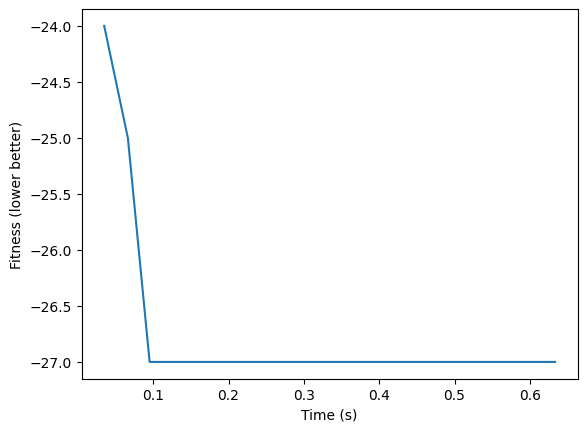

In [5]:
# Pick an optimization method:
# Some examples are 'ledidi', 'directed_evolution', etc.
# Full list:
# https://github.com/move37-labs/nucleobench/blob/main/nucleobench/optimizations/__init__.py

# Params to play with.
OPT_NAME = 'ledidi'
NUM_ROUNDS = 20
N_STEPS_PER_ROUND = 20
TARGET_SUBSTR = 'AGTCA'
START_SEQ = 'A' * 10

import numpy as np
from nucleobench import optimizations
opt_obj = optimizations.get_optimization(OPT_NAME)

# Use default initial args, or specify.
opt_init_args = opt_obj.debug_init_args()
opt_run_args = opt_obj.debug_run_args()
if OPT_NAME == 'ledidi':
  opt_init_args['lr'] = 1.0
  opt_init_args['train_batch_size'] = 64

model_fn = CountSubstringModel(substring=TARGET_SUBSTR)
del opt_init_args['model_fn']
del opt_init_args['seed_sequence']
opt = opt_obj(model_fn=model_fn, seed_sequence=START_SEQ, vocab=VOCAB, **opt_init_args)

import tqdm
import time
from matplotlib import pyplot as plt

proposals, losses, times = [], [], []
start_time = time.time()
for i in tqdm.trange(NUM_ROUNDS):
  if opt.is_finished():
      break

  # Take some optimization steps.
  opt.run(
      n_steps=N_STEPS_PER_ROUND,
      **opt_run_args)

  # Get some samples and score them.
  samples = opt.get_samples(n_samples=1)
  scores = model_fn(samples)
  proposals.extend(samples)
  losses.append(np.mean(scores))
  times.append(time.time() - start_time)

  # Print results.
  print(f'After {time.time() - start_time:.2f}s, fitness {losses[-1]:.2f}: {samples[0]}')
plt.plot(times, losses, label=OPT_NAME)
plt.xlabel('Time (s)')
plt.ylabel('Fitness (lower better)')
plt.show()